In [11]:
from Bio import SeqIO
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
import numpy as np

import re
from collections import defaultdict

In [12]:
phylogeny_order = [
    'Chanos_chanos',
    'Triplophysa_siluroides',
    'Triplophysa_tibetana',
    'Triplophysa_dalaica',
    'Danionella_dracula',
    'Danionella_translucida',
    'Danio_jaintianensis',
    'Danio_choprai',
    'Danio_albolineatus',
    'Danio_aesculapii',
    'Danio_rerio',
    'Danio_kyathit',
    'Danio_tinwini',
    'Leuciscus_waleckii',
    'Gobiocypris_rarus',
    'Paracanthobrama_guichenoti',
    'Ctenopharyngodon_idella',
    'Hypophthalmichthys_molitrix',
    'Anabarilius_grahami',
    'Culter_alburnus',
    'Megalobrama_amblycephala',
    'Labeo_rohita',
    'Labeo_catla',
    'Puntigrus_tetrazona',
    'Oxygymnocypris_stewartii',
    'Onychostoma_macrolepis',
    'Cyprinus_carpio',
    'Carassius_auratus',
    'Sinocyclocheilus_rhinocerous',
    'Sinocyclocheilus_anshuiensis',
    'Sinocyclocheilus_grahami',
    'Sinocyclocheilus_maitianheensis',
    'Sinocyclocheilus_anophthalmus'
]

In [20]:
def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

count_df = pd.DataFrame({'species': phylogeny_order})
count_df['finz_znf'] = counts_df.species.apply(count_finz_znf)
print(count_df)

                            species  finz_znf
0                     Chanos_chanos         0
1            Triplophysa_siluroides         0
2              Triplophysa_tibetana         0
3               Triplophysa_dalaica         0
4                Danionella_dracula         0
5            Danionella_translucida         7
6               Danio_jaintianensis        85
7                     Danio_choprai        59
8                Danio_albolineatus       291
9                  Danio_aesculapii       347
10                      Danio_rerio       705
11                    Danio_kyathit       549
12                    Danio_tinwini        90
13               Leuciscus_waleckii        76
14                Gobiocypris_rarus       280
15       Paracanthobrama_guichenoti       264
16          Ctenopharyngodon_idella       199
17      Hypophthalmichthys_molitrix         8
18              Anabarilius_grahami       238
19                  Culter_alburnus       283
20         Megalobrama_amblycephal

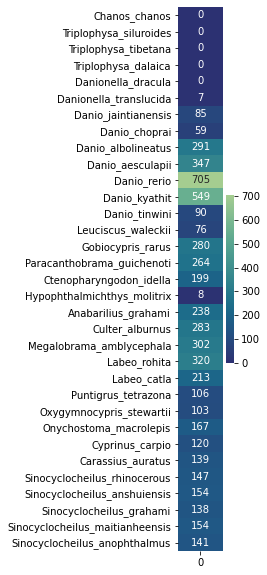

In [21]:
nfinz = [[0]]
for sp in phylogeny_order[1:]:
    nfinz.append(list(count_df.loc[count_df.species == sp, 'finz_znf']))
    
plt.figure(figsize=(1,10))
hm = sns.heatmap(nfinz, cmap='crest_r', annot=True, fmt='d', yticklabels=phylogeny_order)

plt.savefig('../figs/nfinz_heatmap.pdf', dpi=300)
plt.show()

In [2]:
seqdict = {}
for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa', 'fasta'):
    seqdict[record.id] = str(record.seq)

In [3]:
seqlens = [(key, len(val)) for key, val in seqdict.items()]
seq_df = pd.DataFrame(seqlens, columns=['name', 'length'])
seq_df['species'] = seq_df.name.apply(lambda x: '_'.join(x.split('_')[:2]))
print(seq_df.head())

                        name  length              species
0  Danio_jaintianensis_g2.t1     525  Danio_jaintianensis
1  Danio_jaintianensis_g3.t1     466  Danio_jaintianensis
2  Danio_jaintianensis_g4.t1     272  Danio_jaintianensis
3  Danio_jaintianensis_g5.t1     347  Danio_jaintianensis
4  Danio_jaintianensis_g7.t1     449  Danio_jaintianensis


In [4]:
def extract_exons(species, genelist):
    exons = defaultdict(int)
    with open(f'../data/gffs/{species}_augustus_finz.gff') as infile:
        for line in infile:
            if line.startswith('#'):
                continue
            line = line.split()
            if line[2] != 'CDS':
                continue
            parent = re.search('Parent=(.+)$', line[8]).group(1)
            exons[f'{species}_{parent}'] += 1
    return {key: exons[key] for key in genelist}

In [5]:
for species in set(seq_df.species.tolist()):
    genelist = seq_df.loc[seq_df.species == species, 'name'].tolist()
    exons = extract_exons(species, genelist)
    seq_df.loc[seq_df.species == species, 'exons'] = seq_df['name'].apply(exons.get)
print(seq_df.head())

                        name  length              species  exons
0  Danio_jaintianensis_g2.t1     525  Danio_jaintianensis    5.0
1  Danio_jaintianensis_g3.t1     466  Danio_jaintianensis    3.0
2  Danio_jaintianensis_g4.t1     272  Danio_jaintianensis    2.0
3  Danio_jaintianensis_g5.t1     347  Danio_jaintianensis    3.0
4  Danio_jaintianensis_g7.t1     449  Danio_jaintianensis    3.0


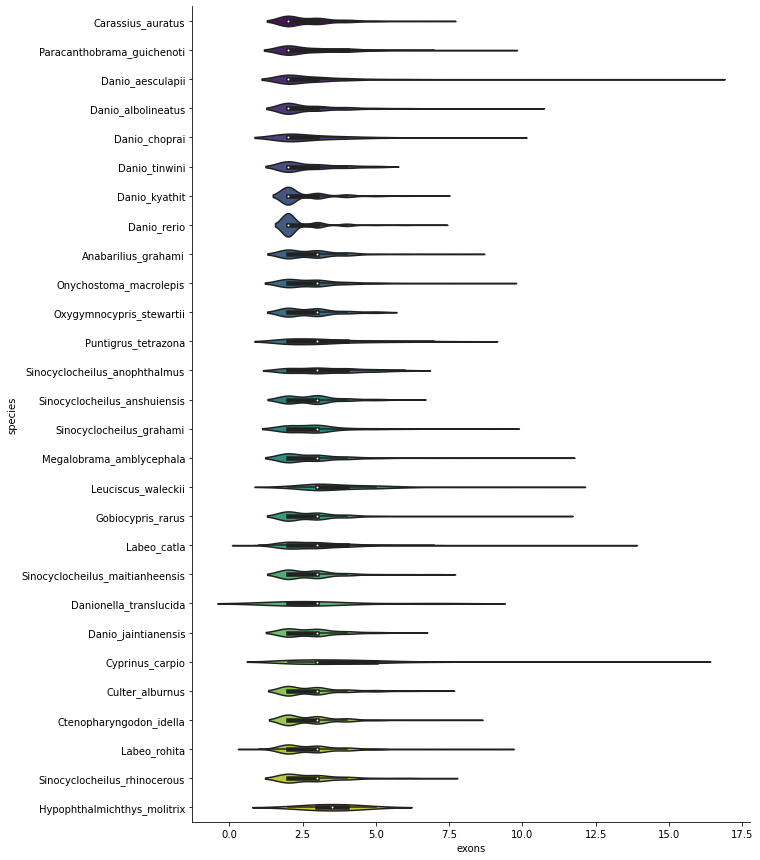

In [7]:
sortorder = seq_df.groupby('species').median().reset_index().sort_values('exons').species.tolist()
fig, ax = plt.subplots(figsize=(10, 15))
sns.violinplot(data=seq_df, x='exons', y='species', order=sortorder, palette='viridis')
sns.despine()
plt.show()

In [9]:
gff_files = {'newannots': '../data/gffs/denovo_finz_znf.gff',
             'ensembl': '../data/gffs/ensembl_finz_znf.gff',
             'refseq': '../data/gffs/refseq_finz_znf.gff'}

gff_files = {'newannots': '../data/gffs/denovo_finz_znf.gff'}
exondict = defaultdict(int)

for source, filename in gff_files.items():
    with open(filename) as infile:
        for line in infile:
            if re.match('#', line):
                continue
            if re.search('\tCDS\t', line):
                try:
                    gene = re.search('ID=(.+)?\.cds;', line).group(1)
                    exondict[f'{gene}'] += 1
                except:
                    print(line)

exon_df = pd.DataFrame([(key, val) for key, val in exondict.items()], columns=['gene', 'exons'])
exon_df['species'] = 'Danio_rerio'
print(exon_df.head())
print(exon_df.loc[exon_df.species == 'Danio_rerio'].sort_values('exons'))

     gene  exons      species
0   g9.t1      2  Danio_rerio
1  g10.t1      2  Danio_rerio
2  g12.t1      3  Danio_rerio
3  g13.t1      4  Danio_rerio
4  g19.t1      2  Danio_rerio
         gene  exons      species
0       g9.t1      2  Danio_rerio
414  g1422.t1      2  Danio_rerio
413  g1421.t1      2  Danio_rerio
412  g1415.t1      2  Danio_rerio
410  g1396.t1      2  Danio_rerio
..        ...    ...          ...
190   g643.t1     10  Danio_rerio
328  g1080.t1     10  Danio_rerio
93    g283.t1     10  Danio_rerio
570  g1946.t1     12  Danio_rerio
262   g871.t1     13  Danio_rerio

[816 rows x 3 columns]


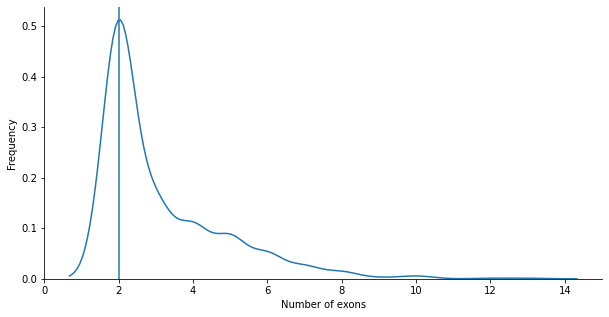

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.hist(exon_df.exons, bins=len(set(exon_df.exons)), density=True)
# dist.plot.kde(exon_df.exons, ax=ax)
sns.kdeplot(exon_df.loc[exon_df.species == 'Danio_rerio'].exons)
plt.axvline(exon_df.loc[exon_df.species == 'Danio_rerio', 'exons'].median())
ax.set_xlabel('Number of exons')
ax.set_ylabel('Frequency')
sns.despine()
plt.show()


In [36]:
exon_df.loc[exon_df.exons == 2].gene.to_csv('../data/test.txt', index=False, header=False)

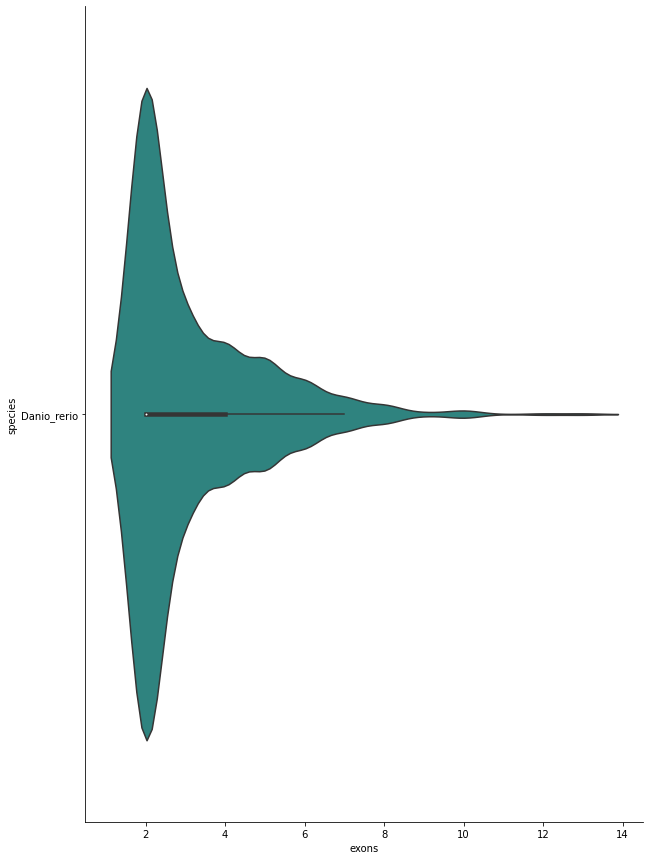

In [27]:
sortorder = exon_df.groupby('species').median().reset_index().sort_values('exons').species.tolist()
fig, ax = plt.subplots(figsize=(10, 15))
sns.violinplot(data=exon_df, x='exons', y='species', order=sortorder, palette='viridis')
sns.despine()
plt.show()

TypeError: venn3() got an unexpected keyword argument 'linestyle'

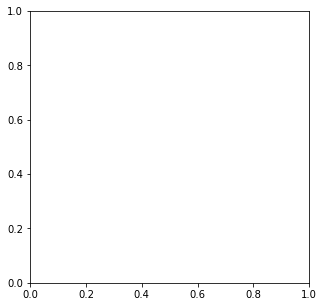

In [11]:
with open('../data/finz_znf_overlap_70.txt') as infile:
    overlap = [int(line.split()[-1]) for line in infile]
# (A, B, AB, C, AC, BC, ABC)
fig, ax = plt.subplots(figsize=(5, 5))
venn3(subsets=overlap, 
      set_labels=('de novo', 'Ensembl', 'RefSeq'), 
      set_colors=('purple', 'dodgerblue', 'orange'), linestyle='-')
plt.show()


In [7]:
print(+171+71+62)
print(122+171+71+57)
print(62+71+57+80)

816
421
270
